# Uczenie SLP z wykorzystaniem algorytmu genetycznego - część 1

Ten plik zawiera notatnik, w którym wykonuje zadanie na ocene 3.

---

## Przygotowanie środowiska.


Importuję potrzebne biblioteki.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

%matplotlib inline

Pobieram dane i wyświetlam 5 ostatnich wierszy.

In [2]:
s ='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
print('URL:', s)
df = pd.read_csv(s,
header=None,
encoding='utf-8')

df.tail(5)

URL: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


---

## Przygotowanie danych.

W poniższej komórce przygotowuję dane:
- tworzę zbiór y, czyli zbiór odpowiedzi,
- przycinam dane ze zmiennej X i w rezultacie zostaje z 2 kolumnami, przez co problem staje się 2-wymiarowy.
- Przesuwam zbiór '*versicolor*' w prawo i w dół, przec co problem staje się liniowo separowalny 

Następnie wyświetlam graficznie zbiór danych X.

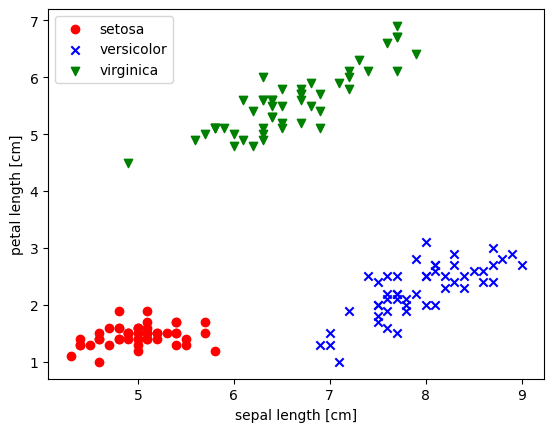

In [3]:
names = df.iloc[:, 4].values
y = [0, 0, 0]
y[0] = np.where(names == 'Iris-setosa', 1, -1)
y[1] = np.where(names == 'Iris-versicolor', 1, -1)
y[2] = np.where(names == 'Iris-virginica', 1, -1)


X = df.iloc[:, [0, 2]].values

X[50:100, 0] += 2   # przesunięcie zbioru versicolor w prawo
X[50:100, 1] -= 2   # przesunięcie zbioru versicolor w dół
# problem staje się liniowo separowalny

plt.scatter(X[:50, 0], X[:50, 1],
color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
color='blue', marker='x', label='versicolor')
plt.scatter(X[100:150, 0], X[100:150, 1],
color='green', marker='v', label='virginica')
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

---

## Klasy

Klasa Perceptron - żadnych zmian względem poprzednich projektów.

In [4]:
class Perceptron(object):
  def __init__(self, eta=0.01, n_iter=50, random_state=1):
    self.eta = eta
    self.n_iter = n_iter
    self.random_state = random_state

  def fit(self, X, y):
    rgen = np.random.RandomState(self.random_state)
    self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
    self.errors_ = []
    for _ in range(self.n_iter):
      errors = 0
      for xi, target in zip(X, y):
        update = self.eta * (target - self.predict(xi))
        self.w_[1:] += update * xi
        self.w_[0] += update
        errors += int(update != 0.0)
      self.errors_.append(errors)
    return self
  
  def net_input(self, X):
    return np.dot(X, self.w_[1:]) + self.w_[0]
  
  def predict(self, X):
    return np.where(self.net_input(X) >= 0.0, 1, -1)

Klasa SLP - dodano kilka zmian:

- metoda ```create_perceptrons(self, size)``` 
    - tworzy listę perceptronów o podanym rozmiarze. 
    <br><br>
    > *Przydatne przy korzystaniu z algorytmu genetycznego.* 
    <br><br>
- metoda ```predict_weights(self, X, weights)``` 
    - taka sama jak ```predict(self, X)```, lecz w tym przypadku zamieniamy wagi perceptronów, na wagi z wektora podanego w argumencie <br><br>
- metoda ```misclassified_weights(self, y, X, weights)``` 
    - taka sama jak ```misclassified(self, y, X)```, lecz w tym przypadku wywołujemy metodę ```predict_weights(self, X, weights)``` przekazując wartości ```values``` z obiektu typu ```Weight``` podanego w dodatkowym argumencie.

In [5]:
class SLP(object):
  def __init__(self, eta=0.01, n_iter=50, random_state=1):
    self.eta = eta
    self.n_iter = n_iter
    self.random_state = random_state

  def create_perceptrons(self, size):
    self.perceptrons_ = []
    for i in range(0, size):
      self.perceptrons_.append(Perceptron(eta=self.eta, n_iter=self.n_iter, random_state=self.random_state))

  def fit(self, X, y):
    self.errors_ = []
    self.perceptrons_ = []
    for i in range(0, len(y)):
      self.perceptrons_.append(Perceptron(eta=self.eta, n_iter=self.n_iter, random_state=self.random_state))
      self.perceptrons_[i].fit(X, y[i])
      if len(self.errors_) == 0:
        self.errors_ = self.perceptrons_[i].errors_
      else:
        self.errors_ = [sum(j) for j in zip(self.errors_, self.perceptrons_[i].errors_)]

  def predict(self, X):
    self.predictions = [0] * len(self.perceptrons_)
    for i in range(0, len(self.perceptrons_)):
      self.predictions[i] = self.perceptrons_[i].predict(X)
    return self.predictions
  
  def misclassified(self, y, X):
    result = 0
    predictions = self.predict(X)
    predictions = [list(map(lambda x: int(x * (-1)), i)) for i in predictions]
    for i in range(0, len(y)):
      result =  result + (sum(map(lambda x: abs(x) // 2, map(sum, zip(predictions[i], y[i])))))
    return result
  
  def predict_weights(self, X, weights):
    self.predictions = [0] * len(self.perceptrons_)
    for i in range(0, len(self.perceptrons_)):
      start_weights = i * (1 + X.shape[1])
      end_weights = (i + 1) * (1 + X.shape[1])

      self.perceptrons_[i].w_ = weights[start_weights:end_weights]
      self.predictions[i] = self.perceptrons_[i].predict(X)

    return self.predictions

  def misclassified_weights(self, y, X, weights):
    result = 0
    predictions = self.predict_weights(X, weights.values)
    predictions = [list(map(lambda x: int(x * (-1)), i)) for i in predictions]
    for i in range(0, len(y)):
      result += (sum(map(lambda x: abs(x) // 2, map(sum, zip(predictions[i], y[i])))))
    return result

Klasa Weight:
- atrybuty:
    - ```values``` -> wektor, który reprezentuje wagi przekazywane do perceptronów.
    - ```errors``` -> liczba całkowita, która zawiera informację o ilości popełnionych błędów przy próbie predykcji za pomocą wag z wektora ```values```.
    <br><br>
- metoda ```set_random(self, lower_bound=-100, upper_bound=100)``` 
    - ustawia losowe wartości wag z podanego w argumentach zakresu.
<br><br>
- metoda ```fit(self, X, y)``` 
    - dokonuje oceny wag zawartych w atrybucie ```values``` i zapisuje ilość błędów do zmiennej ```errors```.

In [6]:
class Weight:
    def __init__(self, slp, values):
        self.slp = slp
        self.values = values
        self.errors = 0

    def set_random(self, lower_bound=-100, upper_bound=100):
        for i in range(0, len(self.values)):
            self.values[i] = random.uniform(lower_bound, upper_bound)

    def fit(self, X, y):
        self.errors = self.slp.misclassified_weights(y, X, self)

Klasa Gen_SLP:
- atrybuty:
    - ```slp``` -> obiekt typu ```SLP``` wykorzystywany do predykcji.
    - ```max_iter``` -> liczba całkowita, która określa maksymalną ilość iteracji algorytmu genetycznego.
    - ```size``` -> liczba całkowita, która określa rozmiar populacji.
    - ```lower_bound``` -> liczba całkowita, która określa dolny zakres losowania wag.
    - ```upper_bound``` -> liczba całkowita, która określa górny zakres losowania wag.
    - ```random_state``` -> liczba całkowita, która określa ziarno losowania.
    - ```best_errors``` -> lista, która zawiera informację o ilości błędów najlepszego osobnika w każdej iteracji.
    - ```avg_errors``` -> lista, która zawiera informację o średniej ilości błędów w każdej iteracji.
    - ```weights``` -> lista, która zawiera obiekty typu ```Weight```, które reprezentują osobniki w populacji.
    <br><br>
- metoda ```sort_weights(self, low, high)``` 
    - sortuje osobniki w populacji według ilości błędów, od najmniejszej do największej, za pomocą algorytmu sortowania szybkiego.
    <br><br>
- metoda ```next_generation(self)``` 
    - tworzy nową populację na podstawie instrukcji podanych w zadaniu.
    <br><br>
- metoda ```append_stats(self)``` 
    - dodaje do list ```best_errors``` i ```avg_errors``` informacje o ilości błędów najlepszego osobnika i średniej ilości błędów w populacji.
    <br><br>
- metoda ```show_stats(self)``` 
    - wyświetla wykres ilości błędów najlepszego osobnika i średniej ilości błędów w populacji w każdej iteracji.
    <br><br>
- metoda ```fit(self, X, y)``` 
    - rozpoczyna proces uczenia algorytmu genetycznego.

In [12]:
class Gen_SLP:
    def __init__(self, slp, max_iter=1000, size=100, lower_bound=-100, upper_bound=100, random_state=1):
        random.seed(random_state)
        self.slp = slp
        self.max_iter = max_iter
        self.size = size
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.random_state = random_state

        self.best_errors = []
        self.avg_errors = []

        self.weights = []

    def sort_weights(self, low, high):
        if low < high:
            pivot = self.weights[high-1]
            i = low
            for x in range(low, high-1):
                if self.weights[x].errors <= pivot.errors:
                    (self.weights[i], self.weights[x]) = (self.weights[x], self.weights[i])
                    i = i + 1
 
            (self.weights[i], self.weights[high - 1]) = (self.weights[high - 1], self.weights[i])

            pi = i
 
            self.sort_weights(low, pi)
            self.sort_weights(pi + 1, high)

    def next_generation(self):
        new_weights = []
        for i in range(0, self.size // 10):
            new_weights.append(self.weights[i])

        for i in range(self.size // 10, self.size):
            p1 = 0
            p2 = 0
            while p1 == p2:
                p1 = random.randint(0,49)
                p2 = random.randint(0,49)

            par1 = self.weights[p1]
            par2 = self.weights[p2]

            mutation = Weight(self.slp, [0] * len(self.weights[0].values))
            mutation.set_random(self.lower_bound, self.upper_bound)

            for y in range(0, len(mutation.values)):
                r = random.random()
                if r < 0.45:
                    mutation.values[y] = par1.values[y]
                elif r >= 0.45 and r < 0.90:
                    mutation.values[y] = par2.values[y]
      
            new_weights.append(mutation)
            
        self.weights = new_weights
        return new_weights    

    def append_stats(self):
        self.best_errors.append(self.weights[0].errors)
        self.avg_errors.append(sum([x.errors for x in self.weights]) / self.size)

    def show_stats(self):
        plt.plot(range(0, len(self.best_errors)), self.best_errors, marker='o', label='Najlepszy wynik')
        plt.plot(range(0, len(self.avg_errors)), self.avg_errors, marker='o', label='Średni wynik')
        plt.xlabel('Generacja')
        plt.ylabel('Ilość błędów')
        plt.legend()
        plt.show()

    def fit(self, X, y):
        # tworzona jest populacja początkowa
        self.weights = []
        for i in range(0, self.size):
            self.weights.append(Weight(self.slp, [0] * ((1 + X.shape[1]) * len(y))))
            self.weights[i].set_random(self.lower_bound, self.upper_bound)
            self.weights[i].fit(X, y)
        
        self.sort_weights(0, self.size)
        self.append_stats()

        # wyświetlenie wyników dla populacji początkowej
        print('Iteracja 1: ')
        print(f'Najlepszy wynik:\n Ilość błędów: {self.best_errors[0]}')
        print(f'Średni wynik:\n Ilość błędów: {self.avg_errors[0]}')
        
        print(self.weights[0].values)

        for i in range(1, self.max_iter):
            self.weights = self.next_generation()
            for x in self.weights:
                x.fit(X, y)
            self.sort_weights(0, self.size)
            self.append_stats()

            if self.best_errors[i] == 0:
                print(f'Iteracja {i + 1}: ')
                print(f'Najlepszy wynik:\n Ilość błędów: {self.best_errors[i]}')
                print(f'Średni wynik:\n Ilość błędów: {self.avg_errors[i]}')
                print(f'Najlepsze wagi: {self.weights[0].values}')
                self.show_stats()
                break
            
            # do sprawdzania postępu algorytmu:
            
            # if (i + 1) % 10 == 0:
            #     print(f'Iteracja {i + 1}: ')
            #     print(f'Najlepszy wynik:\n Ilość błędów: {self.best_errors[i]}')
            #     print(f'Średni wynik:\n Ilość błędów: {self.avg_errors[i]}')
            #     print(f'Najlepsze wagi: {self.weights[40].values}')



---

## Testowanie zwykłego uczenia linowego SLP.

Tworzę obiekt typu ```SLP``` , dokonuję uczenia i wyświetlam wyniki.

Liczba błędnie sklasyfikowanych próbek: 0


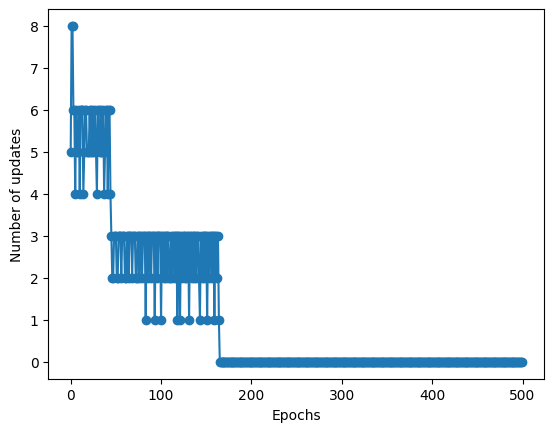

CPU times: total: 1.64 s
Wall time: 1.64 s


In [13]:
%%time
slp = SLP(eta=0.01, n_iter=500)
slp.fit(X, y)
print(f'Liczba błędnie sklasyfikowanych próbek: {slp.misclassified(y, X)}')
plt.plot(range(0, len(slp.errors_) ), slp.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

Jak widać, algorytm uczenia liniowego do nauczenia się tego problemu potrzebuje około 160 iteracji a czas trwania uczenia wynosi około 1.6 sekundy.

---

## Testowanie algorytmu genetycznego.

Tworzony jest obiekt typu ```Gen_SLP``` i dokonywane jest uczenie.

Iteracja 1: 
Najlepszy wynik:
 Ilość błędów: 84
Średni wynik:
 Ilość błędów: 225.97
[0.7022831885201011, -0.08309264471529065, -0.6204789435785716, -0.40129144942767137, 0.38266895178077354, -0.9889858433489138, -0.7599107053598033, -0.3946927262471327, 0.7743827103664336]
Iteracja 368: 
Najlepszy wynik:
 Ilość błędów: 0
Średni wynik:
 Ilość błędów: 58.93
Najlepsze wagi: [0.43646352089185303, -0.05533148916147468, -0.054430845260267535, -0.9151571427026675, 0.14535706622394629, -0.05872083941460038, 0.5234795147058084, -0.48095452681945505, 0.7326124895751625]


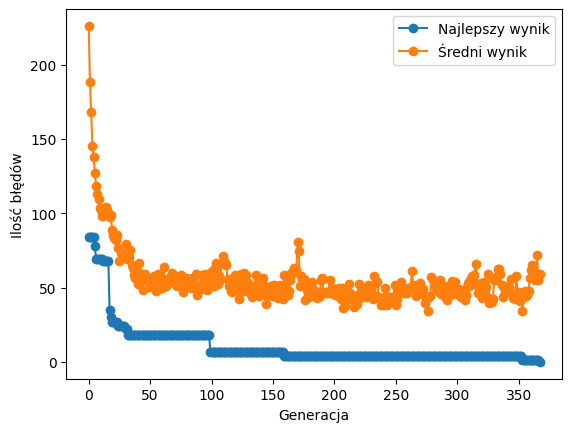

CPU times: total: 6.97 s
Wall time: 6.85 s


In [14]:
%%time
slp = SLP()
slp.create_perceptrons(len(y))
ga = Gen_SLP(slp, max_iter=10000, lower_bound=-1, upper_bound=1, size=100, random_state=1)
ga.fit(X, y)

Na nauczenie algorytmu genetycznego potrzeba było dokładnie 368 iteracji, a czas trwania uczenia wyniósł prawie 7 sekund.

Ilość iteracji, jak i czas trwania uczenia jest wysoce zależna od ziarna losowania.

Na koniec sprawdzam, czy nauka algorytmu genetycznego rzeczywiście przebiegła pomyślnie, porównując wynik funkcji ```predict_weights``` ze zbiorem odpowiedzi ```y```. 

In [15]:
predicted = slp.predict_weights(X, ga.weights[0].values)
np.array_equal(predicted, y)

True